In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab
import matplotlib.ticker as mtick
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['font.family'] = ['sans-serif']

价值函数曲线

In [2]:
x1 = np.arange(0,50,0.1)
x2 = np.arange(-50,0,0.1)
y1 = x1**0.40
y2 = -2.25*(-x2)**0.40

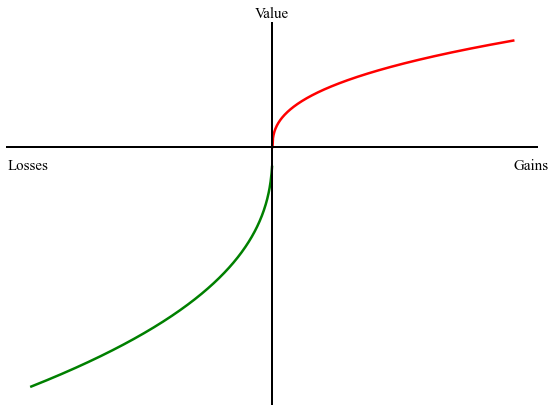

In [3]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

fig = plt.figure(figsize=(9.5, 7))
plt.plot(x1,y1,color = '#ff0000',linewidth =2.5)
plt.plot(x2,y2,color = '#008000',linewidth =2.5)

ax = plt.gca()#获取坐标轴
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('axes', 0.5))
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.title(u'Value',fontproperties = 'Times New Roman',size = 15)

plt.annotate("Gains", (50,-1), xycoords='data',xytext=(50,-1),fontsize=15,fontproperties = 'Times New Roman')
plt.annotate("Losses", (-55,-1), xycoords='data',xytext=(-55,-1),fontsize=15,fontproperties = 'Times New Roman')

plt.xticks([])
plt.yticks([])
#plt.savefig('value_function.pdf',dpi = 300)
plt.show()

城市群地图

In [1]:
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.globals import CurrentConfig, NotebookType
import pandas as pd
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot

In [2]:
province = ['北京市','天津市','河北省',
            '上海市','江苏省','浙江省','安徽省',
            '广东省',
            '湖北省','湖南省','江西省',
            '重庆市','四川省']
df_province = pd.DataFrame({'省份': province,
                   '数值': [-1.78,-1.78,-1.78,
                          -3.18,-3.18,-3.18,-3.18,
                          -2.47,
                          -1.42,-1.42,-1.42,
                          -1.45,-1.45
                           ]
                  })

df_province.head()

,省份,数值
0,北京市,-1.78
1,天津市,-1.78
2,河北省,-1.78
3,上海市,-3.18
4,江苏省,-3.18


In [3]:
# CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
data_province = df_province.loc[:, '省份':].apply(list, axis=1).to_list()

In [4]:
c = (
    Map(init_opts=opts.InitOpts(width = "1000px",height = "700px"))
    .add(
        '省份',
        data_province,
        "china",
        label_opts=opts.LabelOpts(is_show=False),
        is_map_symbol_show=False,
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(min_=-4, max_=-1.42,is_show = True, range_color=["#ff0000","#fd3030","#fa6060","#f89090","#f5c0c0"]),  
    legend_opts = opts.LegendOpts(is_show= False)
    )
)

In [5]:
# 渲染的html保存为pdf图片
#make_snapshot(snapshot, c.render(), "C:/Users/Lenovo/Desktop/Diagram of English label/urban_province_plot.pdf")
make_snapshot(snapshot, c.render(), "urban_province_plot.png")

粉丝等级回归拟合图

In [41]:
import math
import lmfit
import json
import os
import numpy as np
import pandas as pd
from math import log
from pandas import Series
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.sans-serif'] = ['SimHei'] 

In [83]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(9, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, c = '#4ea64e', label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, c = '#fb5050',label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    #plt.plot(union_x_n, union_y_n, c='grey')
    #plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c = '#008000', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], '--', c = '#008000', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], '-',c = '#ff0000',linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('Level Ⅲ', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    
    #plt.savefig('level_Ⅲ.pdf',dpi = 300)
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

In [84]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('$Level{I}$', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [85]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

In [89]:
olhc_gender_bins = pd.read_csv('olhc_gender.csv')

收益率与粉丝等级1
return > 0
---------- 收益率 < 0 ----------
相关性： -0.43442549896841776
参数： -1215.9869807026025 10442.614178837117
R^2： 0.18872551415395933
[[Variables]]
    k: -1215.98698 +/- 181.475864 (14.92%) (init = 1000)
    b:  10442.6142 +/- 452.661174 (4.33%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.2317487424627025
参数： 763.2620187815495 9556.19088078688
R^2： 0.05370747963304412
[[Variables]]
    k:  763.262019 +/- 201.422838 (26.39%) (init = -1000)
    b:  9556.19088 +/- 367.770698 (3.85%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.5931448844313918
平衡点： 0.4478584040114525


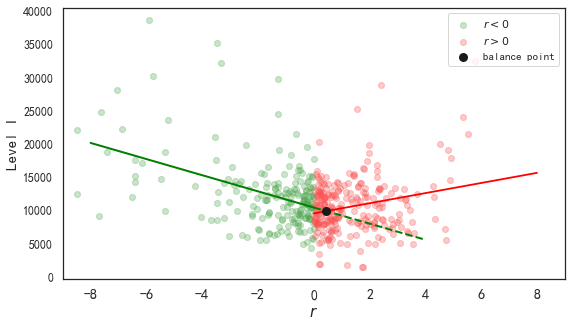

收益率为0： 1.0927590615453724
收益率为1： 1.1297693078309698
收益率为2： 1.1616817932333066
收益率为4： 1.2139164112255596
收益率为6： 1.254869374312464


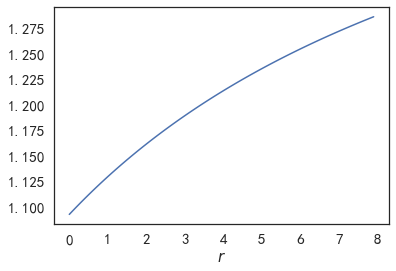

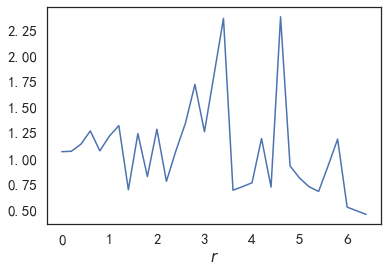

return > 0
[[Variables]]
    A1:  6.7950e-04 +/- 0.00263901 (388.37%) (init = 1000)
    A2:  9.86932975 +/- 2.27326887 (23.03%) (init = 1)
    b:   10292.6158 +/- 236.792036 (2.30%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.185
    C(A2, b)  = 0.181
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  813.615814 +/- 599.009831 (73.62%) (init = 1215.987)
    A2:  1.20803473 +/- 0.36908402 (30.55%) (init = 1.5)
    b:   10756.8554 +/- 638.639525 (5.94%) (init = 10442.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.979
    C(A1, b)  = -0.813
    C(A2, b)  = 0.749


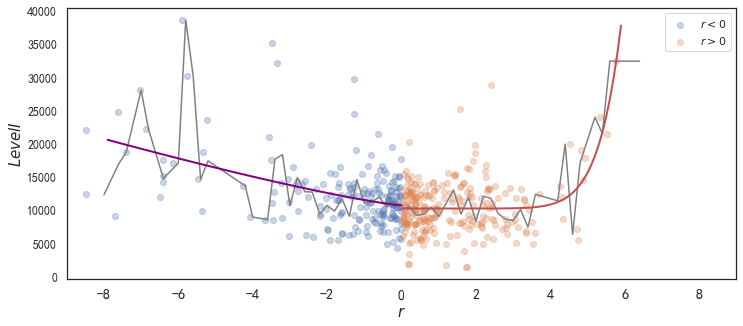

收益率为0.5： 1.0793209017988097
收益率为1： 1.1241525613638796
收益率为2： 1.2276483194127048
收益率为4： 1.3868966812256847
收益率为6： 0.4168791393949951


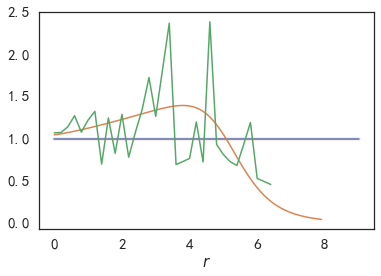

In [78]:
#粉丝等级拟合回归图
print("收益率与粉丝等级1")
x_n = olhc_gender_bins.close[olhc_gender_bins.close<0]
y_n = olhc_gender_bins.fol1[olhc_gender_bins.close<0]
x = olhc_gender_bins.close[olhc_gender_bins.close>0]
y = olhc_gender_bins.fol1[olhc_gender_bins.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与粉丝等级2
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5242067784390269
参数： -2651.8986601385714 19147.028813444467
R^2： 0.27479274656142316
[[Variables]]
    k: -2651.89866 +/- 310.103529 (11.69%) (init = 1000)
    b:  19147.0288 +/- 773.501353 (4.04%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.26034954219097517
参数： 1429.1534054000965 18100.66140222863
R^2： 0.0677818841190504
[[Variables]]
    k:  1429.15341 +/- 333.211928 (23.32%) (init = -1000)
    b:  18100.6614 +/- 608.399654 (3.36%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.855573131700416
平衡点： 0.25639648659511144


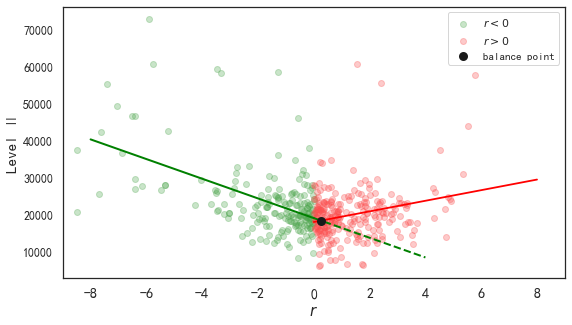

收益率为0： 1.0578082418075068
收益率为1： 1.1161871061402977
收益率为2： 1.166604476193734
收益率为4： 1.2492874782790835
收益率为6： 1.314251400086217


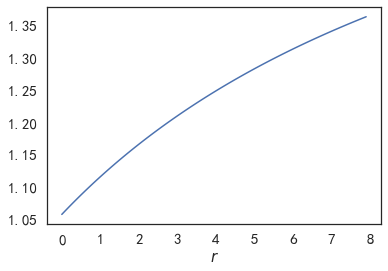

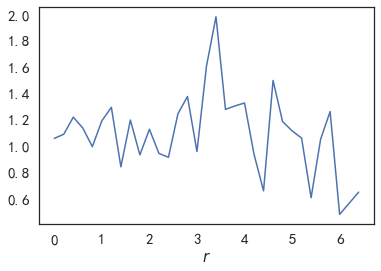

return > 0
[[Variables]]
    A1:  2.0690e-05 +/- 1.0908e-04 (527.24%) (init = 1000)
    A2:  12.1767990 +/- 3.04684117 (25.02%) (init = 1)
    b:   19610.5644 +/- 395.001072 (2.01%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.164
    C(A2, b)  = 0.161
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1511.32319 +/- 915.029355 (60.54%) (init = 2651.899)
    A2:  1.29298899 +/- 0.30457092 (23.56%) (init = 1.5)
    b:   20038.4468 +/- 1032.67685 (5.15%) (init = 19147.03)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.982
    C(A1, b)  = -0.790
    C(A2, b)  = 0.730


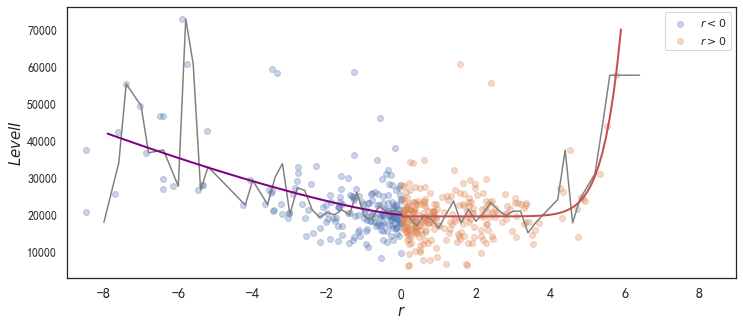

收益率为0.5： 1.0532702866608874
收益率为1： 1.0988857594513894
收益率为2： 1.2106538126579005
收益率为4： 1.4517120571254156
收益率为6： 0.43430299709843445


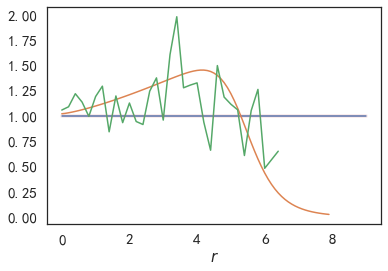

In [82]:
#粉丝等级拟合回归图
print("收益率与粉丝等级2")
x_n = olhc_gender_bins.close[olhc_gender_bins.close<0]
y_n = olhc_gender_bins.fol2[olhc_gender_bins.close<0]
x = olhc_gender_bins.close[olhc_gender_bins.close>0]
y = olhc_gender_bins.fol2[olhc_gender_bins.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与粉丝等级3
return > 0
---------- 收益率 < 0 ----------
相关性： -0.02353316808779753
参数： -21.020242646750944 4673.84422757592
R^2： 0.0005538100002484558
[[Variables]]
    k: -21.0202426 +/- 64.2774120 (305.79%) (init = 1000)
    b:  4673.84423 +/- 160.329251 (3.43%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： -0.17095351428908806
参数： -251.12306086624307 4601.268043033228
R^2： 0.02922510404778933
[[Variables]]
    k: -251.123061 +/- 90.9929140 (36.23%) (init = -1000)
    b:  4601.26804 +/- 166.140681 (3.61%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： 0.08370494758323713
平衡点： -0.3154076299641924


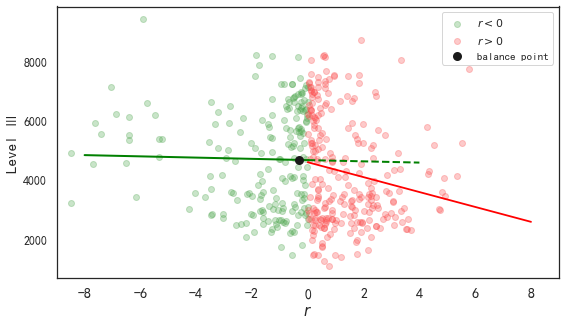

收益率为0： 1.0157730833900405
收益率为1： 1.0792432182074
收益率为2： 1.1504902397235608
收益率为4： 1.3228306303478934
收益率为6： 1.5511131522944033


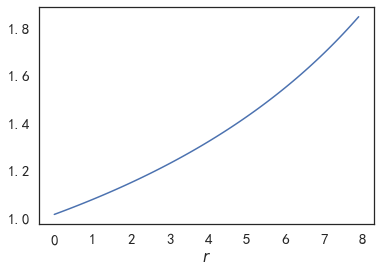

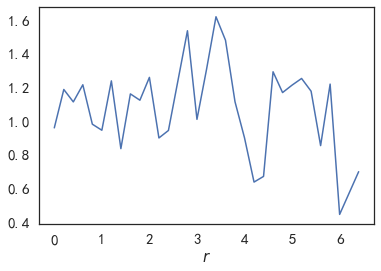

return > 0
[[Variables]]
    A1: -265108.738 +/- 58311909.6 (21995.47%) (init = 1000)
    A2:  0.00135798 +/- 0.30753542 (22646.57%) (init = 1)
    b:   269277.160 +/- 58311843.1 (21654.95%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = -1.000
    C(A1, A2) = 1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  3.02779082 +/- 25.7169575 (849.36%) (init = 21.02024)
    A2:  2.69030282 +/- 4.22185570 (156.93%) (init = 1.5)
    b:   4649.07714 +/- 144.398225 (3.11%) (init = 4673.844)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.996
    C(A1, b)  = -0.480
    C(A2, b)  = 0.454


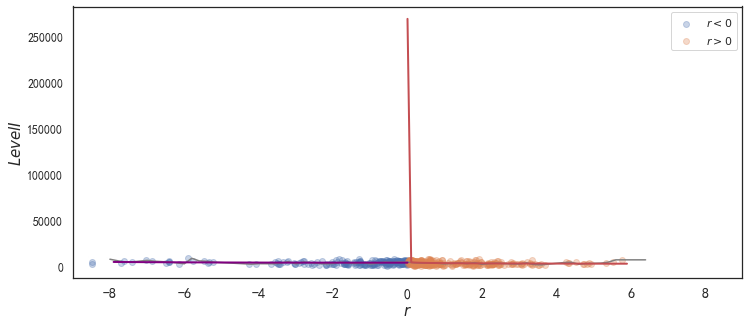

收益率为0.5： 1.0524464388392591
收益率为1： 1.116034965970636
收益率为2： 1.1913502570174885
收益率为4： 1.3015496389290382
收益率为6： 1.4263849923297436


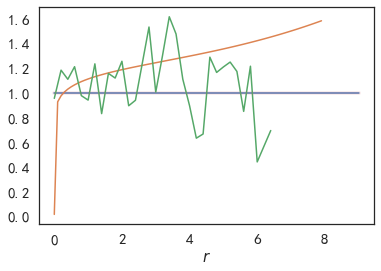

In [86]:
#粉丝等级拟合回归图
print("收益率与粉丝等级3")
x_n = olhc_gender_bins.close[olhc_gender_bins.close<0]
y_n = olhc_gender_bins.fol3[olhc_gender_bins.close<0]
x = olhc_gender_bins.close[olhc_gender_bins.close>0]
y = olhc_gender_bins.fol3[olhc_gender_bins.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

性别层面pointplot

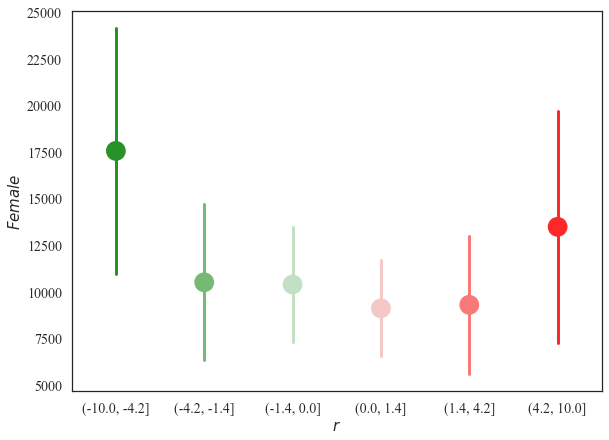

In [93]:
#女性pointplot

fig, ax = plt.subplots(1,1,figsize=(9.5,7))
sns.set_theme(style="white")
#flatui = ["#348634", "#7eb17e", "#c8dcc8", "#efcece", "#e98888","#e24343"]
flatui = ["#279327", "#75b975", "#c4e0c4", "#f5c8c8", "#f97878","#fd2828"]
sns.pointplot(x = 'bins',y = 'f',data = olhc_gender_bins,ax = ax,join = False,ci = 'sd',catsize = 1,scale=2.25,
                order = ['(-10.0, -4.2]','(-4.2, -1.4]','(-1.4, 0.0]','(0.0, 1.4]','(1.4, 4.2]','(4.2, 10.0]'],
               palette=sns.color_palette(flatui),saturation=1,errwidth = 3,markers='o')
plt.xlabel('$r$',fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('$Female$',fontdict={'weight': 'normal', 'size': 15})
plt.yticks(fontproperties = 'Times New Roman',size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)

plt.savefig('C:/Users/Lenovo/Desktop/Diagram of English label/Female.pdf',dpi = 300)
plt.show()

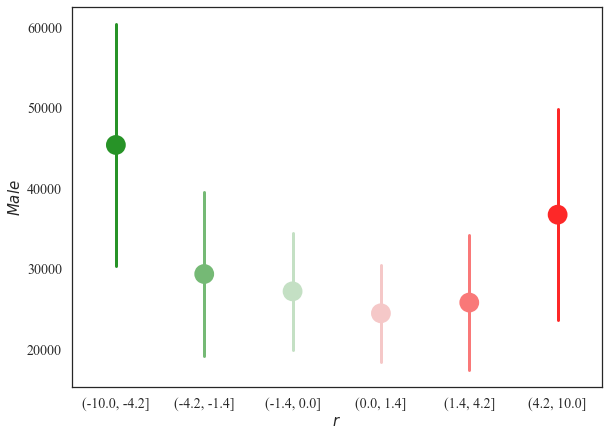

In [94]:
#男性pointplot
fig, ax = plt.subplots(1,1,figsize=(9.5,7))
sns.set_theme(style="white")
#flatui = ["#348634", "#7eb17e", "#c8dcc8", "#efcece", "#e98888","#e24343"]
flatui = ["#279327", "#75b975", "#c4e0c4", "#f5c8c8", "#f97878","#fd2828"]
sns.pointplot(x = 'bins',y = 'm',data = olhc_gender_bins,ax = ax,join = False,ci = 'sd',catsize = 1,scale=2.25,
                order = ['(-10.0, -4.2]','(-4.2, -1.4]','(-1.4, 0.0]','(0.0, 1.4]','(1.4, 4.2]','(4.2, 10.0]'],
               palette=sns.color_palette(flatui),saturation=1,errwidth = 3,markers='o')
plt.xlabel('$r$',fontdict={'weight': 'normal', 'size': 15})
plt.ylabel('$Male$',fontdict={'weight': 'normal', 'size': 15})
plt.yticks(fontproperties = 'Times New Roman',size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)

plt.savefig('C:/Users/Lenovo/Desktop/Diagram of English label/Male.pdf',dpi = 300)
plt.show()